In [1]:
import pyproj
import itertools
import numpy as np
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

## Read magnetic anomaly data from Rio de Janeiro

In [2]:
# Fetch magnetic anomaly data from Rio de Janeiro
data = hm.datasets.fetch_rio_magnetic()

# Reduce region of the survey to speed things up
region = [-42.60, -42.40, -22.32, -22.20]
inside = vd.inside((data.longitude.values, data.latitude.values), region)
data = data[inside]

# Project coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data["easting"], data["northing"] = projection(
    data.longitude.values, data.latitude.values
)
coordinates = (data["easting"], data["northing"], data.altitude_m)

## Model selection

In [3]:
# Build combination of parameters
depth_factors = [0.75, 1, 1.5, 2, 3, 4, 5]
k_nearest_s = [3, 5, 10]

# Use itertools to create a list with all combinations of parameters to test
parameter_sets = [
    dict(depth_factor=combo[0], k_nearest=combo[1])
    for combo in itertools.product(depth_factors, k_nearest_s)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 21


In [4]:
scores = []
gridder = hm.EQLHarmonic()

for params in parameter_sets:
    gridder.set_params(**params)
    shuffle = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)
    score = np.mean(
        vd.cross_val_score(
            gridder, coordinates, data.total_field_anomaly_nt, cv=shuffle
        )
    )
    scores.append(score)
print("Scores: {}".format(scores))

Scores: [0.9854951147340871, 0.9873648005883217, 0.9453442528512337, 0.980422157590161, 0.9810512542143639, -1.5605013929957297, 0.7884683915141881, -14.707285816304383, -9030.235584652291, 0.9143580047195405, -2.067074559212407, -16351.341436294091, -154.44505488539033, -20196.117098374194, -3552.8089212767727, -602.7791319245233, -35084.91536585406, -2668.2361260649095, -5344.634149661752, -17374.998837625717, -796.7212421962182]


In [11]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

params = parameter_sets[best]
gridder.set_params(**params)
gridder.fit(coordinates, data.total_field_anomaly_nt)

Best score: 0.9873648005883217
Best parameters: {'depth_factor': 0.75, 'k_nearest': 5}


EQLHarmonic(damping=None, depth_factor=0.75, k_nearest=5, points=None)

## Predict values on a regular grid

In [12]:
# Interpolate data into the regular grid at 200m above the sea level
region = vd.get_region(coordinates)
grid = gridder.grid(
    region=region, spacing=250, data_names=["magnetic_anomaly"], extra_coords=200
)

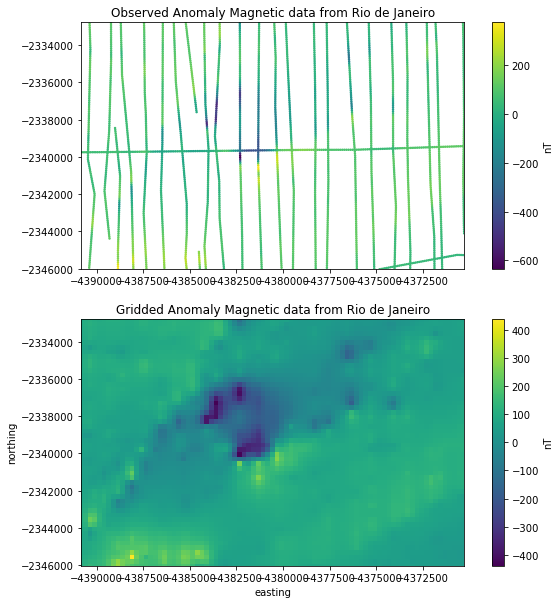

In [13]:
# Plot original magnetic anomaly
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
tmp = ax1.scatter(data.easting, data.northing, c=data.total_field_anomaly_nt, s=2)
plt.colorbar(tmp, ax=ax1, label="nT")
ax1.set_xlim(*region[:2])
ax1.set_ylim(*region[2:])
ax1.set_aspect("equal")
ax1.set_title("Observed Anomaly Magnetic data from Rio de Janeiro")

# Plot gridded magnetic anomaly
tmp = grid.magnetic_anomaly.plot.pcolormesh(ax=ax2, add_colorbar=False, cmap="viridis")
plt.colorbar(tmp, ax=ax2, label="nT")
ax2.set_xlim(*region[:2])
ax2.set_ylim(*region[2:])
ax2.set_aspect("equal")
ax2.set_title("Gridded Anomaly Magnetic data from Rio de Janeiro")
plt.show()